# OPTaaS: Surrogate Visualization

The surrogate model is what the optimizer *thinks* the scoring function looks like. It is part of the mechanism used to choose optimal configurations.

You may wish to see a visualization of this surrogate model, to identify areas of interest, and to gain further insights into your problem.

First, create and run a simple optimization task...

## Run a simple task on 3D optimizing a cubic well
Follow a similar pattern to previous tutorials

In [1]:
## Connect to OPTaaS using your API Key
from mindfoundry.optaas.client.client import OPTaaSClient
client = OPTaaSClient('https://optaas.mindfoundry.ai', '<Your OPTaaS API Key>')

## Create task
from mindfoundry.optaas.client.parameter import FloatParameter
from mindfoundry.optaas.client.client import Goal

task = client.create_task(
    title='Basic 2D Example',
    parameters=[
        FloatParameter('x', minimum=-1, maximum=2),
        FloatParameter('y', minimum=-1, maximum=2),
        FloatParameter('z', minimum=-1, maximum=2)
    ],
    goal=Goal.min,
)

## Define the scoring function
def scoring_function(x, y, z):
    ''' A simple well with min at 0, 0, 0'''
    score = x**2 + y**2 + z**2
    return score

## Run the task
best_result = task.run(scoring_function, max_iterations=15)
print("Best Result:", best_result)

Running task "Basic 2D Example" for 15 iterations
(no score threshold set)

Iteration: 0    Score: 0.75
Configuration: {'x': 0.5, 'y': 0.5, 'z': 0.5}

Iteration: 1    Score: 3.1875
Configuration: {'x': 1.25, 'y': -0.25, 'z': 1.25}

Iteration: 2    Score: 1.6875
Configuration: {'x': -0.25, 'y': 1.25, 'z': -0.25}

Iteration: 3    Score: 0.796875
Configuration: {'x': 0.875, 'y': 0.125, 'z': 0.125}

Iteration: 4    Score: 5.671875
Configuration: {'x': -0.625, 'y': 1.625, 'z': 1.625}

Iteration: 5    Score: 1.171875
Configuration: {'x': 0.125, 'y': -0.625, 'z': 0.875}

Iteration: 6    Score: 3.796875
Configuration: {'x': 1.625, 'y': 0.875, 'z': -0.625}

Iteration: 7    Score: 0.19921875
Configuration: {'x': -0.0625, 'y': -0.0625, 'z': -0.4375}

Iteration: 8    Score: 5.26171875
Configuration: {'x': 1.4375, 'y': 1.4375, 'z': 1.0625}

Iteration: 9    Score: 4.41796875
Configuration: {'x': 0.6875, 'y': -0.8125, 'z': 1.8125}

Iteration: 10    Score: 2.1416231688839638
Configuration: {'x': -1.0,

## Visualizing the surrogate
We will plot a representation of the surrogate model. We do this in three steps:
    
- Create a large number of random configurations and the surrogate predictions for them
- Project them onto a 2D space
- Plot mean and variance

## Generate 500 random configurations

In [2]:
import numpy as np

random_configs_values = [{'x': np.random.uniform(-1, 2), 
                          'y': np.random.uniform(-1, 2),
                          'z': np.random.uniform(-1, 2)} for _ in range(500)]

predictions = task.get_surrogate_predictions(random_configs_values)

## Project onto 2D space using PCA
The problem exists in 3 dimensions, which is unwieldy to plot. Use PCA projection to reduce dimensionality.

In [3]:
from sklearn.decomposition.pca import PCA

surrogate_X = [[c['x'], c['y'], c['z']] for c in random_configs_values]

pca = PCA(n_components=2)
surrogate_projected = pca.fit_transform(surrogate_X)

mean = [p.mean['score'] for p in predictions]
var = [p.variance['score'] for p in predictions]

### Now calculate the projection of the evaluation points

In [4]:
results = task.get_results(include_configurations=True)

evaluations_config_values = [r.configuration.values for r in results]
evaluations_score = [r.score for r in results]

evaluations_X = [[c['x'], c['y'], c['z']] for c in evaluations_config_values]
evaluations_projected = pca.transform(evaluations_X)

### Plot the projected points

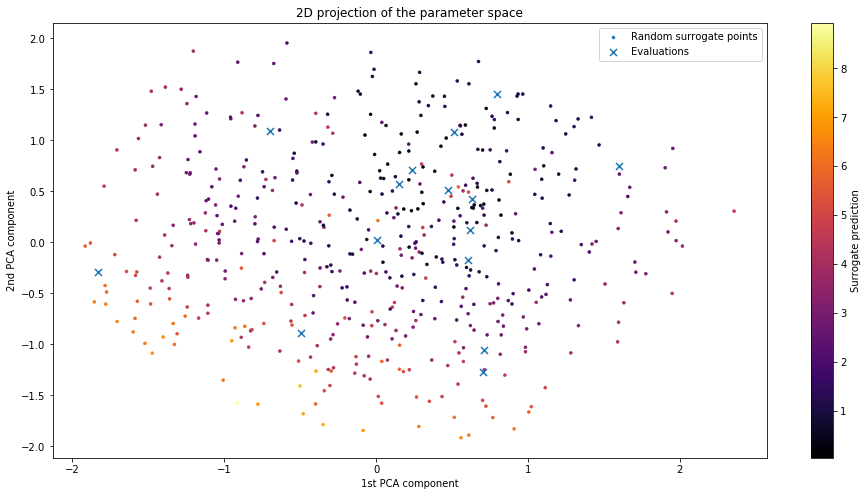

In [5]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.figure(figsize=(16,8))
plt.scatter(x=surrogate_projected[:, 0], y=surrogate_projected[:, 1], cmap='inferno', c=mean, marker='.', label='Random surrogate points', linewidths=0.5)
cbar = plt.colorbar()
cbar.set_label('Surrogate prediction')

plt.scatter(x=evaluations_projected[:, 0], y=evaluations_projected[:, 1], label='Evaluations', marker='x', s=50)
plt.xlabel('1st PCA component')
plt.ylabel('2nd PCA component')

plt.title('2D projection of the parameter space')
plt.legend()
plt.show()

## Want to know more?
Here's an article we wrote on how the surrogate works: https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0